In [0]:
import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize

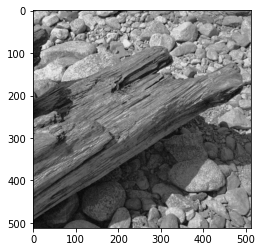

In [207]:
data = scipy.io.loadmat('/content/drive/My Drive/CS25025/HW4/IMAGES_RAW.mat') 
images = data['IMAGESr']

#Show the first image.
plt.imshow(images[:,:, 0], cmap='gray')

In [208]:
images.shape

(512, 512, 10)

In [0]:
# Function to sample image patches from the large images. 
def sample_random_square_patches(image, num, width):
    patches =np.zeros([width,width,num]); 
    for k in range(num):
        i, j = random.sample(range(image.shape[0]-width),2)
        patches[:,:,k] = image[i:i+width,j:j+width] 
    return patches

In [0]:
# Part (a) - (b)

In [0]:
# Create a function that transforms each image to an array of shape (width^2, 1)

In [0]:
def transform_image(images):
    trans = []
    for i in range(images.shape[2]):
        trans.append(images[:,:,i].flatten())

    return np.array(trans).T

In [0]:
patches = sample_random_square_patches(images[:,:,0], 100, 12)

In [214]:
X = transform_image(patches)
X.shape

(144, 100)

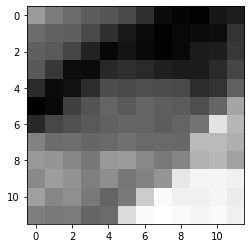

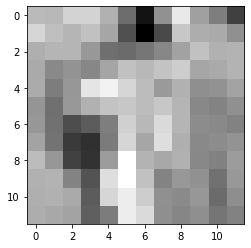

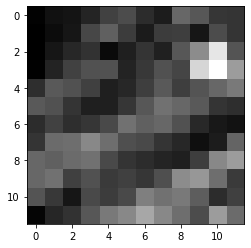

In [215]:
for i in range(3):
    plt.imshow(X[:, i].reshape(12, 12), cmap = "gray")
    plt.show()

In [0]:
# Create a function that initializes the codebook by generating random numbers 
# between minimum and maximum values in the image 

In [0]:
def create_cb(images, d2, pred):
    V = np.random.normal(0, 1, d2 * pred).reshape(d2, pred)
    return normalize(V, axis = 0) 

In [218]:
V_ex = create_cb(images, 12 ** 2, 3)
V_ex.shape

(144, 3)

In [0]:
# Create a function that computes coefficients using Lasso, using no loops

In [0]:
def find_coef(V, X):
    clf = Lasso(alpha = 0.01, fit_intercept = False, tol = 0.0001, normalize = False, \
                precompute = False, max_iter = 1000, warm_start = False)
    clf.fit(V, X)
    coef = np.array(clf.coef_)
    
    return coef.T

In [221]:
A = find_coef(V_ex, X)
A.shape

(3, 100)

In [222]:
A[:, 1]

array([ 0., -0., -0.])

In [0]:
# Try to calling Lasso on each training point separately and compare with above result

In [224]:
start1 = time.time()
coef1 = find_coef(V_ex, X)
print(time.time() - start1)
print(coef1[:10, :10])

0.017562150955200195
[[ 0.          0.         -0.          0.          0.         -0.21895774
   0.42362804  0.          0.         -0.        ]
 [-0.         -0.          0.         -0.         -0.         -0.
  -0.         -0.          0.         -0.        ]
 [ 0.         -0.         -0.         -0.         -0.         -0.19911193
   0.         -0.          0.          0.        ]]


In [225]:
start2 = time.time()
coef2 = []
for i in range(A.shape[1]):
    clf = Lasso(alpha = 0.01, fit_intercept = False, tol = 0.0001, normalize = False, \
                precompute = False, max_iter = 1000, warm_start = False)
    clf.fit(V_ex, X[:,i])
    coef2.append(clf.coef_)
coef2 = np.array(coef2).T
print(time.time() - start2)
print(coef2[:10, :10])

0.04587149620056152
[[ 0.          0.         -0.          0.          0.         -0.21895774
   0.42362804  0.          0.         -0.        ]
 [-0.         -0.          0.         -0.         -0.         -0.
  -0.         -0.          0.         -0.        ]
 [ 0.         -0.         -0.         -0.         -0.         -0.19911193
   0.         -0.          0.          0.        ]]


In [0]:
# We get the exact same results with both approaches but the former method (using
# matrix operation) is much faster 

In [0]:
# Create a function that performs stochastic gradient descent and update the codebook

In [0]:
def perform_sgd(A, V, X, step_size):
    resid = np.matmul(V, A) - X
    gradient = - np.matmul(resid, A.T)
    V = V + step_size * gradient
    return normalize(V, axis = 0)

In [0]:
# Part (c)

In [0]:
# Create a function that displays codebook

In [0]:
def display_codebook(V):
    fig = plt.figure(figsize = (5, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        col_vec = V[:, i]
        plt.imshow(col_vec.T.reshape((12, 12)), cmap = "gray")
        plt.axis("off")
    plt.axis("off")
    plt.show()

In [0]:
def run_one_iter(V, image, width, num, step_size):
    patches = sample_random_square_patches(image, num, width)
    X = transform_image(patches)
    A = find_coef(V, X)
    V = perform_sgd(A, V, X, step_size)
    
    patch_ = np.matmul(V, A)
    error = np.linalg.norm(X - patch_)
    
    return V, X, patch_, error

In [0]:
def run_iter(width, pred, num, num_iter, images, step_size, decrease = False, V = []):
    
    if len(V) == 0:
        V = create_cb(images, width * width, pred)
        V = normalize(V, axis = 0)
    
    print("Initial Codebook")
    display_codebook(V)
    
    errors = [] 
    start = time.time()
    for i in range(num_iter):
        index = random.randrange(0, 10)
        image = images[:, :, index]
        if decrease:
            step_size = step_size * 0.999 
        V, X, patch_, error = run_one_iter(V, image, width, num, step_size)
        errors.append(error)

        if i != 0 and i % 100 == 0:
            print("Codebook In - Process")
            display_codebook(V)


    print("Final Codebook")
    display_codebook(V)
    print("process time: {}".format(time.time() - start))
    return V, errors



In [0]:
# Create a function that plots the error. 
# We take the average of the last 10 errors because we want to see 
# where the error converges over time 

In [0]:
def plot_error(errors):
    plt.plot(errors)
    plt.show()
    errors = np.array(errors)
    print("mean error: {}".format(np.mean(errors)))

In [0]:
# First, we try different step sizes and control other inputs

Initial Codebook


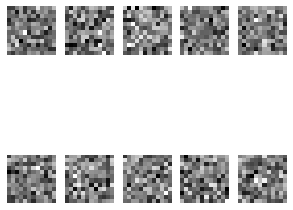

Codebook In - Process


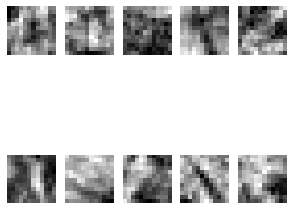

Codebook In - Process


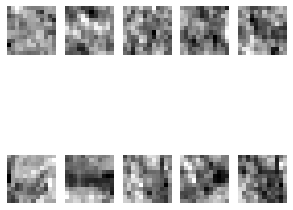

Final Codebook


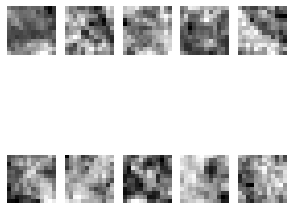

process time: 12.051870584487915


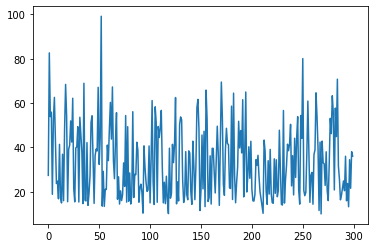

mean error: 33.263389210907846


In [237]:
# Try step_size = 0.1
V, errors = run_iter(12, 200, 25, 300, images, 0.1, decrease = False)
plot_error(errors)

Initial Codebook


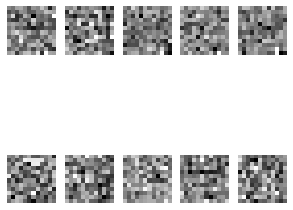

Codebook In - Process


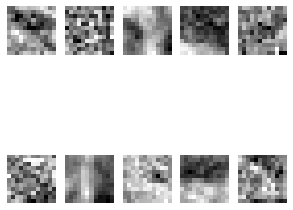

Codebook In - Process


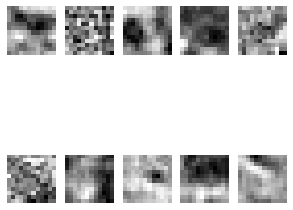

Final Codebook


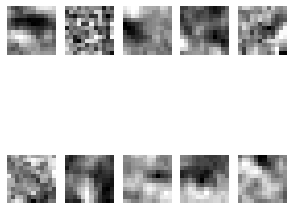

process time: 12.929972887039185


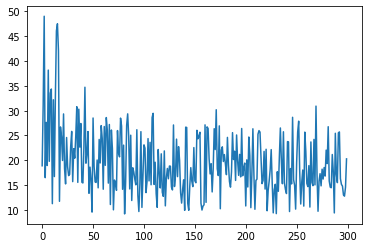

mean error: 19.493617307143403


In [249]:
# Try step_size = 0.01
V, errors = run_iter(12, 200, 25, 300, images, 0.01, decrease = False)
plot_error(errors)

Initial Codebook


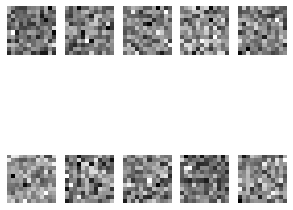

Codebook In - Process


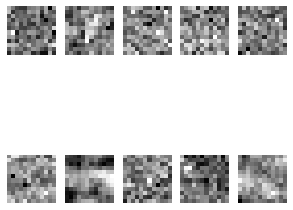

Codebook In - Process


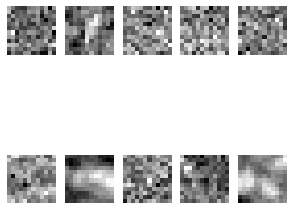

Final Codebook


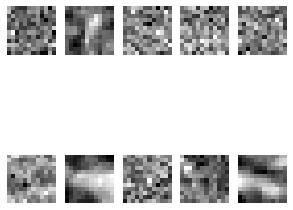

process time: 13.445521831512451


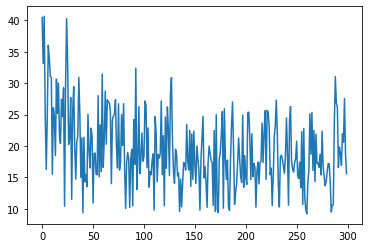

mean error: 19.37873513370462


In [248]:
# Try decreasing step_size with initial value 0.01 
V, errors = run_iter(12, 200, 25, 300, images, 0.01, decrease = True)
plot_error(errors)

In [0]:
# The plots show that for the conditions we experimented above, the codebook
# is constantly updated in every iteration. We can clearly see the improvements 
# in accuracy as iterations proceed. The error rate was lower when we used the 
# step size of 0.01 instead of 0.1. Also, the errors converged nicely when we 
# used decreasing step_size instead of constant stpe size. Now, lets try some 
# other step sizes around 0.1 (tuning)

Initial Codebook


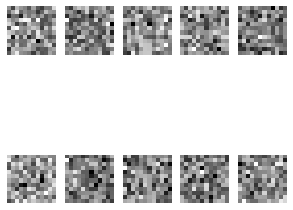

Codebook In - Process


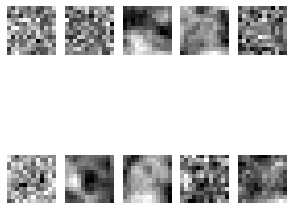

Codebook In - Process


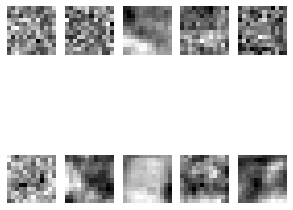

Final Codebook


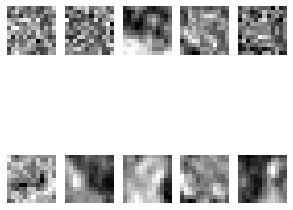

process time: 13.300647497177124


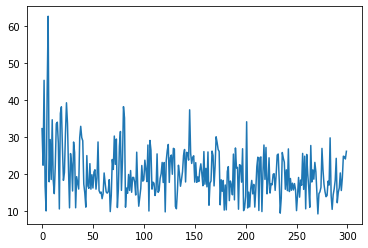

mean error: 20.11550515563558


In [241]:
V, errors = run_iter(12, 200, 25, 300, images, 0.012, decrease = True)
plot_error(errors)

Initial Codebook


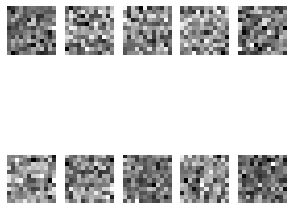

Codebook In - Process


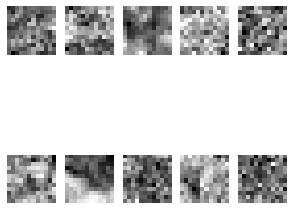

Codebook In - Process


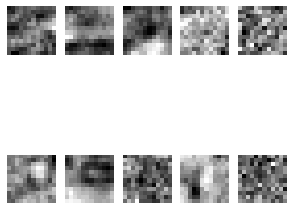

Final Codebook


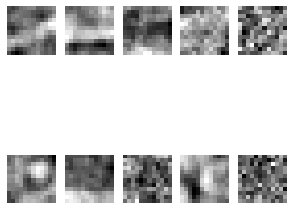

process time: 12.381097793579102


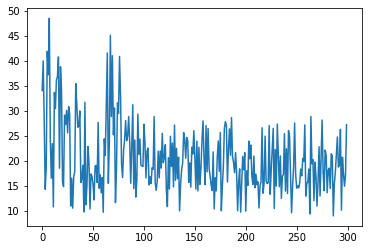

mean error: 20.55679395839318


In [251]:
V, errors = run_iter(12, 200, 25, 300, images, 0.008, decrease = True)
plot_error(errors)

In [0]:
# Looking at the results, it makes sense to use decreasing step size starting 
# from 0.01. Now, let's try longer iterations and check the behavior of convergence 

Initial Codebook


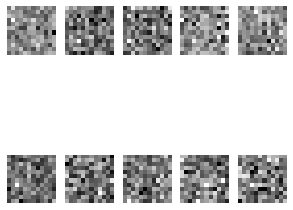

Codebook In - Process


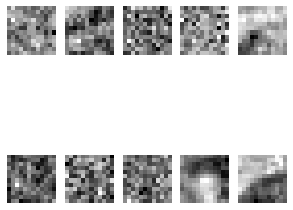

Codebook In - Process


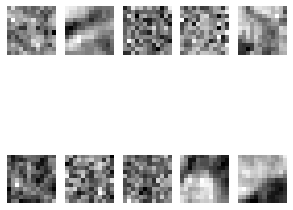

Codebook In - Process


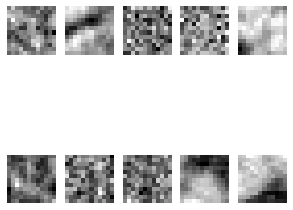

Codebook In - Process


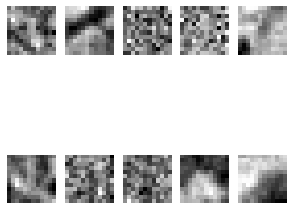

Final Codebook


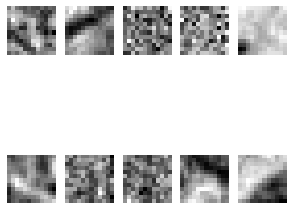

process time: 25.020759105682373


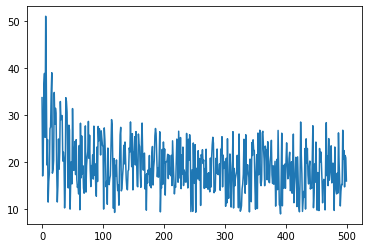

mean error: 19.230111593138066


In [252]:
V1, errors1 = run_iter(12, 200, 25, 500, images, 0.01, decrease = True)
plot_error(errors1)

Initial Codebook


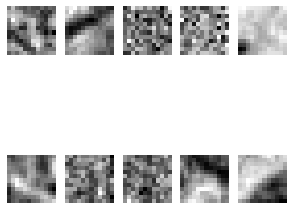

Codebook In - Process


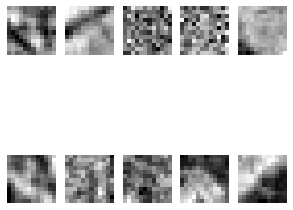

Codebook In - Process


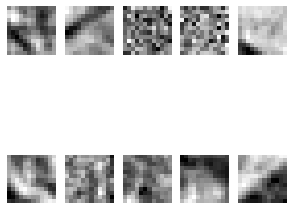

Codebook In - Process


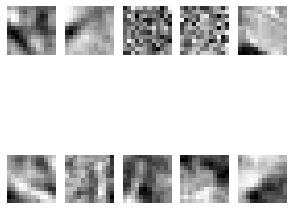

Codebook In - Process


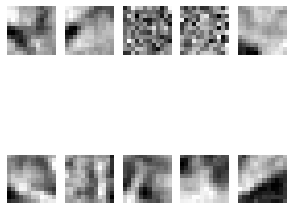

Final Codebook


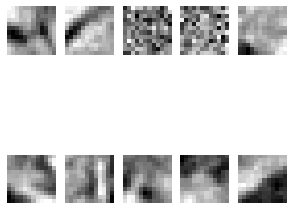

process time: 29.338890075683594


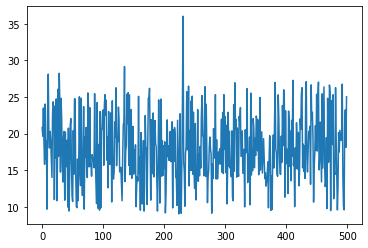

mean error: 17.945029017232482


In [253]:
V2, errors2 = run_iter(12, 200, 25, 500, images, 0.01, decrease = True, V = V1)
plot_error(errors2)

Initial Codebook


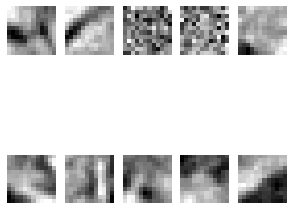

Codebook In - Process


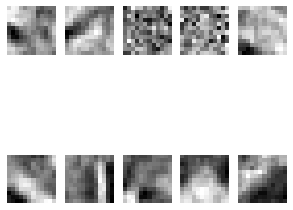

Codebook In - Process


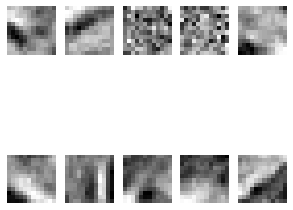

Codebook In - Process


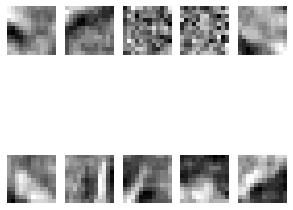

Codebook In - Process


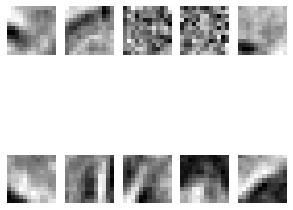

Final Codebook


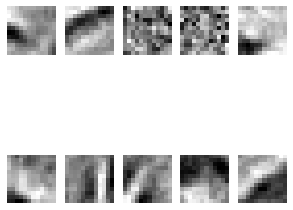

process time: 29.75699543952942


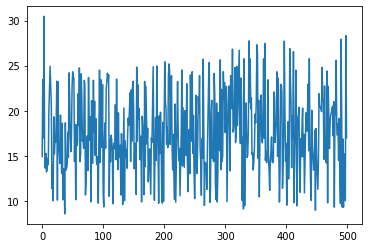

mean error: 17.458128000808088


In [254]:
V3, errors3 = run_iter(12, 200, 25, 500, images, 0.01, decrease = True, V = V2)
plot_error(errors3) 

In [0]:
# After about 1500 iterations, the mean error rate didn't change significantly, 
# meaning that gradient descent algorithm reached somewhere very close to the 
# minimum. It took about 84.1 seconds to reach convergence. Let's take a look 
# at our final codebook. 

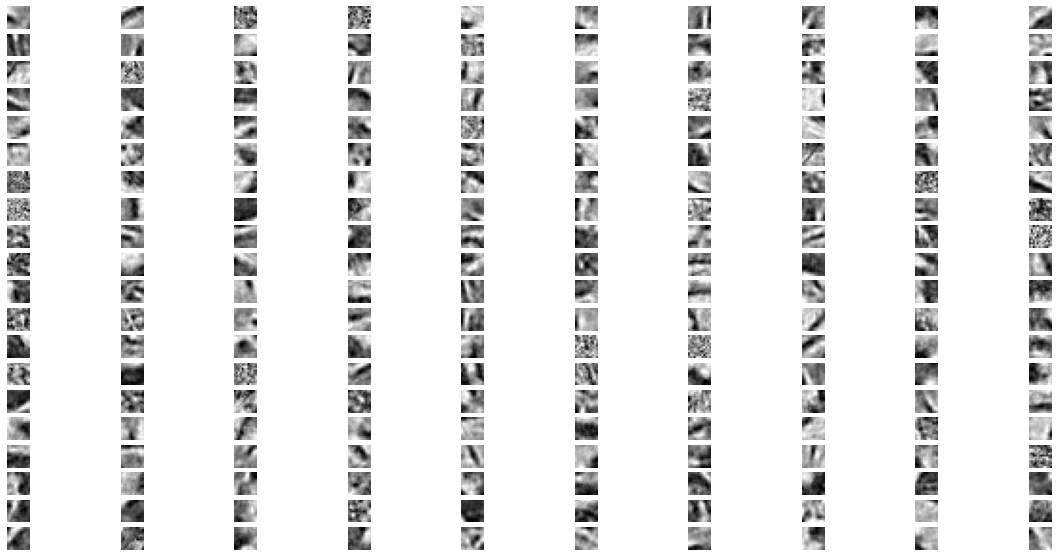

In [257]:
fig = plt.figure(figsize = (20, 10))
for i in range(200):
    plt.subplot(20, 10, i + 1)
    col_vec = V3[:, i]
    plt.imshow(col_vec.reshape((12, 12)), cmap = "gray")
    plt.axis("off")    
plt.axis("off")
plt.show()

In [0]:
# The codebook we obtained may not look completely the same as the figures in the 
# paper, most entries are definitely very similar. Each element in the codebook 
# seems to capture the orientation of black and white and their boundaries. 

In [0]:
# Part (c)

In [0]:
# function that reconstructs patch images using sparse representation 

In [0]:
def recon_patch(images, width, V, pred):
    for k in range(images.shape[2]):
        image = images[:, :, k]        
        patches = []
        for i in range(int(len(image) / width)):
            for j in range(int(len(image) / width)):
                patches.append(image[i* width:(i+1)* width, j* width :(j+1)* \
                                     width].flatten())
        X = (np.array(patches)).T
        A = find_coef(V, X)
        recon = np.matmul(V, A)
        s = []
        for i in range(int(len(image) / width)):  
            r = []
            for j in range(int(len(image) / width)): 
                r.append(recon[:, i * int(len(image) / width) + j].reshape(width, \
                                                                         width))
            s.append(np.hstack(tuple(r)))
        recon_image = np.vstack(tuple(s))
        
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.show()
        plt.imshow(recon_image, cmap='gray')
        plt.show()

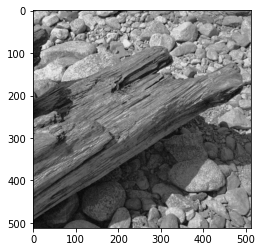

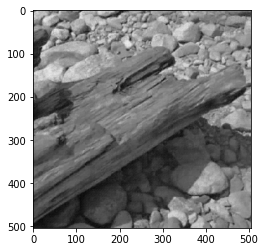

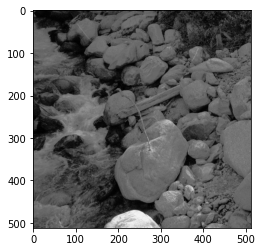

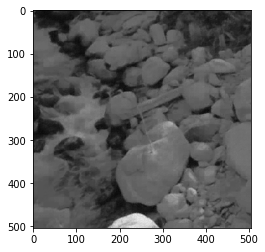

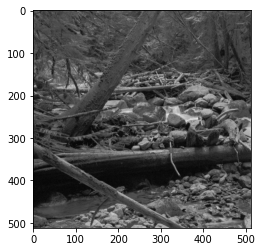

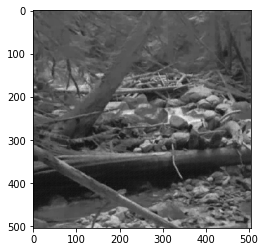

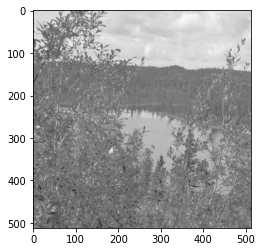

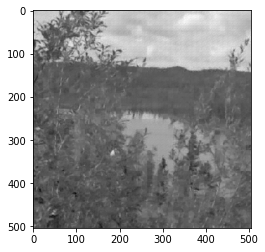

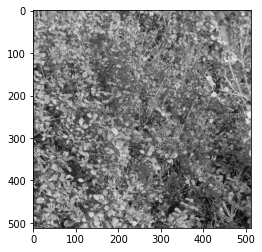

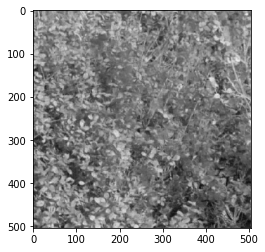

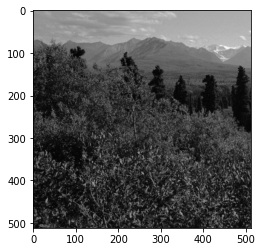

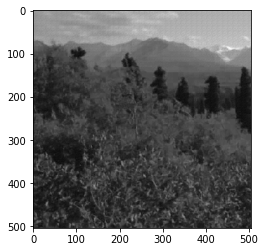

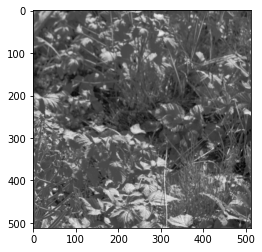

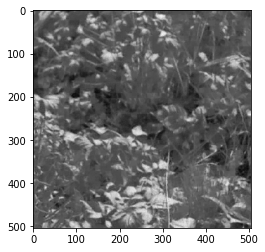

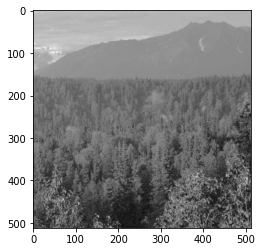

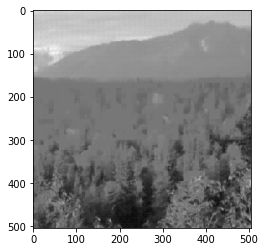

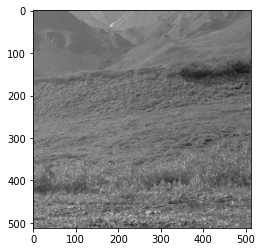

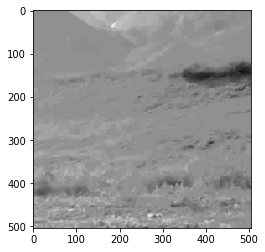

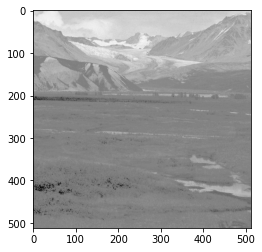

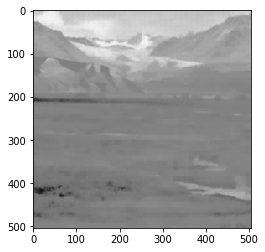

In [266]:
# Lets reconstruct each of the ten images and lay them out in pairs 
recon_patch(images, 12, V3, 200)

In [0]:
# The results are indeed very surprising. We can tell just from the reconstruction 
# what the image represents. 